In [1]:
"""
TIP: 
    1. Never use  [[0]*3]*3 for array assignment - This creates three duplicate list. Check out below code to view the weird result it gives:
        X = [[2]*3]*2
        X[0][0] = 3
        print(X)
        #Extremely weired!!! This is assigning to all the coloumn 0th element to 3.
"""
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from math import *

#TODO: Take input from the user
N = 30                  # Number of oscillators;
NEPOCHS = 400000                 # Duration to run
DT = 0.01             # Time step between each epoch
    
#Constants
DEBUG = 1
MU = 1                   # Oscillator parameter (>0 for supercritical)
EPS = 0.9                # ε - coupling strength for error signal e(t) = D(t) - P(t)
ETA_OMEGA = 0.1       #ηω - ωi' = -ηω*e(t)*sin(Фi) ; 1/η = 0.0001
ETA_ALPHA = 0.0001       #ηα - αi' = ηα*e(t)*ri*cos(Фi)
TAU = 10000              #τ - τ*Wij' = -Wij + zi(zj*)^(ωi/ωj)
DATA_SAMPLES = 20000
DATA_SAMPLES = NEPOCHS #TODO: Delete later

#Initialized at startup
R = np.zeros([N, 1])          # R vector in polar coordinates for N oscillators
PHI = np.zeros([N, 1])        # Ф vector for N oscillators
OMEGA = np.zeros([N, 1])      # Natural frequencies of N oscillators
A = np.zeros([N, N])          # NxN connectivity matrix for N oscillators
THETA = np.zeros([N, N])      # NxN phase angle difference in complex coupling
ALPHA = np.zeros([N, 1])      # NxN weight matrix for phase 1 teaching
IEXT = np.zeros([N, 3])       # For each oscillator external input freq, phase and amplitude

def initialize(N):
    """
    Parameters:
    R:     Initialize everything to 1
    PHI:   2*pi*rand(n, 1) - Uniformly distributed random number from 0 - 2ℼ 
    W:     { 0.01 + 45*2*pi*rand(n,1) - Given} For now assign in steps of 5
    A:     Randomly assign betwwn 0-1 uniformly distributed (TODO: constrain this later)
    THETA: Randomly assign between 0 - 2ℼ uniformly distributed
    APLHA: Initialize all to 0.09
    
    Constrain:
    θ12 = -θ21 = θ
    A12 = A21 = A
    MU = 1
    
    Return: 
    R, PHI, W, A, THETA
    
    Use coloumn vector to avoid ambiguity
    """
    R = 1*np.ones([N, 1]) 
    PHI = 2*pi*np.random.rand(N, 1)
    OMEGA = 30*np.random.rand(N, 1) #np.array([12 + i*15 for i in range(N)])
    #OMEGA = OMEGA[:,None] #Converting to coloumn vector
    print("OMEGA \n", OMEGA)
    print("PHI \n", PHI)
    
    """
        (i) Aij = Aji (ii) Aii = 0
        (ii) θ12 = -θ21 = θ
        Note: Make sure Aii is always zero to avoid numerical issues
    """
    A = np.random.rand(N, 1)
    A = np.dot(A, A.T)
    #A.fill(0.05) #Delete me
    A.fill(0.00001)
    np.fill_diagonal(A, 0)
    print("A \n", A)
    
    THETA = 2*pi*np.random.rand(N, N)
    THETA = (THETA - THETA.T)
    #print("THETA \n", THETA)
    
    ALPHA = 1*np.ones([N, 1])
    IEXT[:,0] = 1                                           #All external input componets have same amplitude
    IEXT[:,1] = np.array([1 + i*1 for i in range(N)])       #Also try setting frequency as that of oscillator itself
    IEXT[:,2] =  np.random.uniform(low=-pi, high=pi, size=(N)) #np.array([pi/2, pi/5])                      #Intially setting phase difference to zero. Later set it to some non zero values
    #print("IEXT \n", IEXT)
    
    #Convert everythint to coloumn vector
    return R, PHI, OMEGA, A, THETA, ALPHA, IEXT
    

In [2]:
def truncated_remainder(dividend, divisor):
    divided_number = dividend / divisor
    divided_number = \
        -int(-divided_number) if divided_number < 0 else int(divided_number)

    remainder = dividend - divisor * divided_number

    return remainder

def transform_to_pipi(input_angle):
    revolutions = int((input_angle + np.sign(input_angle) * pi) / (2 * pi))

    p1 = truncated_remainder(input_angle + np.sign(input_angle) * pi, 2 * pi)
    p2 = (np.sign(np.sign(input_angle)
                  + 2 * (np.sign(fabs((truncated_remainder(input_angle + pi, 2 * pi))
                                      / (2 * pi))) - 1))) * pi

    output_angle = p1 - p2

    return output_angle, revolutions

In [3]:
def Teaching_Signal(IEXT, time):
    signal = 0
    
    Amplitude = IEXT[:,0][:,None] 
    Freq = IEXT[:,1][:,None] 
    Phase = IEXT[:,2][:,None] 
        
    signal = np.sum(Amplitude*np.sin( Freq*time + Phase))
    
    return signal

In [4]:
#TODO: write model here
#TODO: Handle numerical issues due to phi and theta
def model(N, R, PHI, OMEGA, A, THETA, ALPHA, IEXT, NEPOCHS, DATA_SAMPLES):
    """
    Parameters:
    NEPOCHS: How long to run the model
    
    TODO: Later add Iext as well
    
    Return:
    W: Change in W
    PHI: Change in pahse
    N_PHI_DIFF: Normalized pahse difference
    
    Miscellaneous:
        1. Normalized pahse difference approaches zero ss individual oscillators attain equillibrium 
        2. No dynamics for Amplitude of lateral coupling i.e. dA = 0
    """
    # Be careful while changing these assignment!! Check out TIP section
    N_PHI_DIFF = np.zeros([N, N, NEPOCHS]) 
    PHI_ = np.zeros([N, NEPOCHS])
    R_ = np.zeros([N, NEPOCHS])
    OMEGA_ = np.zeros([N, NEPOCHS])
    THETA_ = np.zeros([N, N, NEPOCHS])
    ERR_ = np.zeros(NEPOCHS)
    PTEACH_ = np.zeros(NEPOCHS)
    S_ = np.zeros(NEPOCHS)
    
    S = np.zeros(DATA_SAMPLES) 
    ERR = np.zeros(DATA_SAMPLES)
    PTEACH = np.zeros(DATA_SAMPLES)
    
    for t in range(NEPOCHS):
        # Why are they initializing R and THETA in every epoch?
        #R = 1*np.ones([N, 1]) 
        #PHI = 2*pi*np.random.rand(N, 1)
        
        s = t #TODO: Remove later
        #for s in range(DATA_SAMPLES):
        
        PTEACH[s] = Teaching_Signal(IEXT, DT*s)
        S[s] = np.sum(ALPHA*np.cos(PHI))
        ERR[s] = PTEACH[s] - S[s]

        """
            1. Vector form - do simultaneous update 
            2. Below system handles complex sinusiodal input
            3. In all matrix rows contain source oscillator, and 
               columns represent coupling to corresponding target oscillator

            Caution:
            Use coloumn vector for each oscillator to avoid confusion
        """

        NORM_FREQ = np.multiply(OMEGA, 1/OMEGA.T) #Check #ith row contains ωi/ωj
        NORM_FREQ[np.isnan(NORM_FREQ)] = 0
        NORM_PHASE = (PHI/OMEGA).T - (PHI/OMEGA) + THETA/(OMEGA*OMEGA.T) #Check #Nij = ∅j/ωj - ∅i/ωi + θij/ωiωj
        #To be used for training lateral weights Nij 
        # ∅i/ωi - ∅j/ωj - θij/ωiωj
        PHASE_DIFF = (PHI/OMEGA) - (PHI/OMEGA).T - THETA/(OMEGA*OMEGA.T) #Check

        """
            Causes of NaN
            1. Negative entries in R matrix. Any negative entry in R results in NaN i.e. complex value
        """
        R_POW_NF = R.T#np.power(R.T, NORM_FREQ) #!!!!!!!!!!!Wrong #ith row contains Rj^(ωi/ωj) 

        ARG = OMEGA*NORM_PHASE; #Check
        ARG_2 = OMEGA*PHASE_DIFF; #Check
        R_COUPLED = A*R_POW_NF*np.cos(ARG) #Check
        PHI_COUPLED = A*(R_POW_NF/R)*np.sin(ARG) #Check
        R_COUPLED = np.sum(R_COUPLED, axis=1) 
        PHI_COUPLED = np.sum(PHI_COUPLED, axis=1)
        #Converting to coloumn vector
        R_COUPLED = R_COUPLED[:,None]
        PHI_COUPLED = PHI_COUPLED[:,None]

        if np.isnan(PHI_COUPLED).any() or np.isnan(PHI_COUPLED).any():
            print("\n")
            print("Interaction matrix \n", A)
            print("Frequency \n", OMEGA)
            print("R \n", R)
            print("Phase phi\n", PHI)
            print("Argument \n", ARG)
            print("Norm freq\n", NORM_FREQ, "\n")
            print("Norm phase\n", NORM_PHASE, "\n")
            print("R pow NF\n", R_POW_NF, "\n")
            print("R sum \n", R_COUPLED)
            print("Phi sum \n", PHI_COUPLED)
            break

        Amplitude = IEXT[:,0][:,None]
        Freq = IEXT[:,1][:,None]
        Phase = IEXT[:,2][:,None]

        dR = ( (MU - R**2)*R + R_COUPLED + EPS*ERR[s]*np.cos(PHI) )*DT 
        dPHI = ( OMEGA + PHI_COUPLED - EPS*(ERR[s]/R)*np.sin(PHI) )*DT 
        dOMEGA = -ETA_OMEGA*ERR[s]*np.sin(PHI)*DT
        dALPHA = ETA_ALPHA*ERR[s]*R*np.cos(PHI)*DT
        dTHETA = ((OMEGA.T*R*R_POW_NF/A)*np.sin(ARG_2)) 

        #Equation2
        COMPLEX_W = A*np.exp(1j*THETA/OMEGA.T) #check
        Z1 = R*np.exp(1j*PHI) #Check
        Z2 = R.T*np.exp(-1j*PHI.T) #Check
        Z2_SP = np.power(Z2, OMEGA/OMEGA.T) #Check

        dCOMPLEX_W = (-COMPLEX_W + Z1*Z2_SP)
        COMPLEX_W = COMPLEX_W + dCOMPLEX_W/ETA_OMEGA

        R = R + dR
        PHI = PHI + dPHI
        OMEGA = OMEGA + dOMEGA
        #THETA = THETA + dTHETA/TAU
        ALPHA = ALPHA + dALPHA

        THETA = np.angle(COMPLEX_W)*OMEGA.T
        """
            Corrections:
            1. Non-negative oscillator frequencies
            2. Entries in R mtrix should not be negative
        """
        OMEGA[OMEGA < 0.01] = 0.01 #Restrict frequencies of oscillator to positive range only
        R[R < 0.01] = 0.01         #This avoids NaN restricting R to non-negative values
        np.fill_diagonal(THETA, 0) #This avoids NaN due to 'A' term in the denominator in dTHETA
        np.fill_diagonal(A, 0)

        R_[:,t] = R.T
        PHI_[:,t] = PHI.T
        OMEGA_[:,t] = OMEGA.T
        N_PHI_DIFF[:,:,t] = NORM_PHASE
        THETA_[:,:,t] = THETA
        ERR_[t] = ERR[s]#[DATA_SAMPLES-1] #Uncomment later
        PTEACH_[t] = PTEACH[s]
        S_[t] = S[s]
        
    return R, PHI, R_, PHI_, OMEGA_, N_PHI_DIFF, THETA_, ERR_, PTEACH_, S_

OMEGA 
 [[ 4.70223688]
 [19.82253091]
 [26.4299981 ]
 [11.54451017]
 [29.9781527 ]
 [28.58771436]
 [11.94724562]
 [18.80242794]
 [10.72197042]
 [19.22596747]
 [ 8.64119427]
 [16.87916065]
 [ 6.85835503]
 [ 2.16540412]
 [20.71237921]
 [ 0.93821753]
 [29.52909665]
 [ 8.21280927]
 [ 5.47584102]
 [ 1.70123723]
 [18.00945517]
 [ 2.45437315]
 [15.99663804]
 [25.21461457]
 [17.28626795]
 [14.05750934]
 [16.19459026]
 [ 7.56272028]
 [12.92025076]
 [17.13191338]]
PHI 
 [[2.97386573e+00]
 [5.49087095e+00]
 [4.94814581e+00]
 [5.00108857e+00]
 [2.60329561e+00]
 [2.83280007e+00]
 [3.64254839e+00]
 [1.51440419e+00]
 [6.10186909e+00]
 [1.75861225e+00]
 [2.44407413e+00]
 [2.89591318e-02]
 [2.58718169e+00]
 [1.17255362e-01]
 [3.62226543e+00]
 [5.40498118e+00]
 [2.82967364e+00]
 [3.73170705e+00]
 [2.78966334e+00]
 [5.40180536e+00]
 [4.71827716e+00]
 [1.68755380e+00]
 [6.89676520e-01]
 [5.40191965e-03]
 [4.88920981e+00]
 [4.54138105e+00]
 [4.71551763e+00]
 [5.99690705e+00]
 [8.43023391e-01]
 [5.62307362e

/tmp/ipykernel_1099936/2417742070.py:100: RuntimeWarning: divide by zero encountered in divide
  dTHETA = ((OMEGA.T*R*R_POW_NF/A)*np.sin(ARG_2))
/tmp/ipykernel_1099936/2417742070.py:100: RuntimeWarning: invalid value encountered in multiply
  dTHETA = ((OMEGA.T*R*R_POW_NF/A)*np.sin(ARG_2))


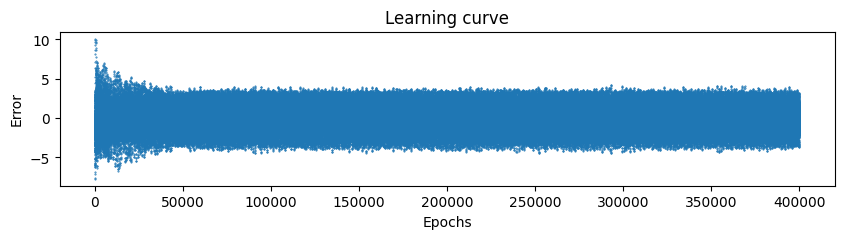

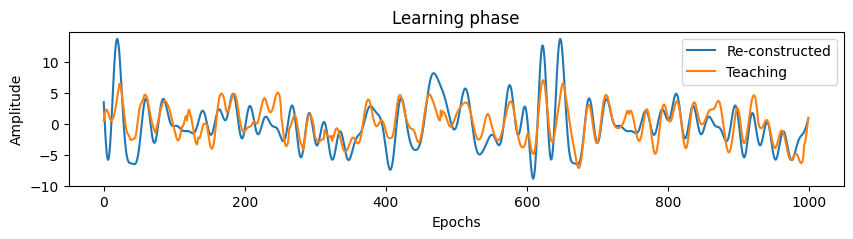

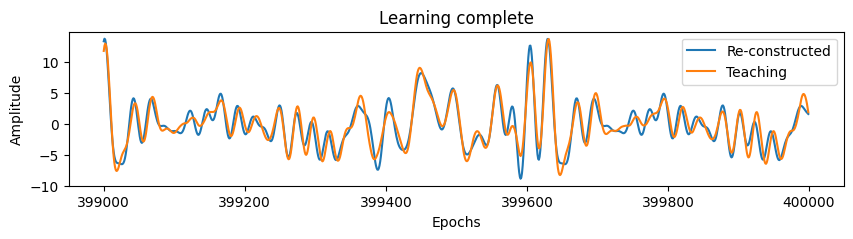

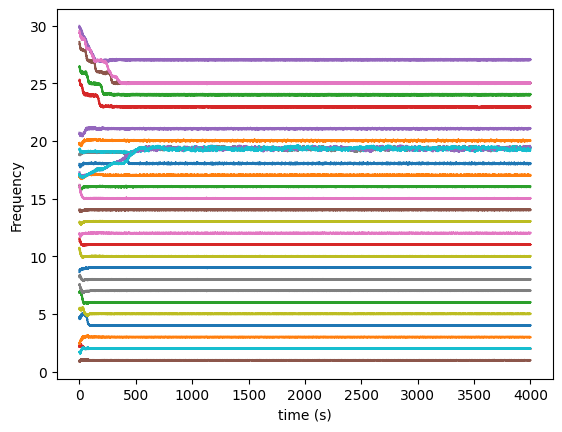

In [5]:
R, PHI, OMEGA, A, THETA, ALPHA, IEXT = initialize(N)
R, PHI, R_, PHI_, OMEGA_, N_PHI_DIFF, THETA_, ERR_, PTEACH_, S_ = model(N, R, PHI, OMEGA, A, THETA, ALPHA, IEXT, NEPOCHS, DATA_SAMPLES)

epochs = [i for i in range(NEPOCHS)]
t = np.multiply(epochs, DT)
X = [np.multiply(R_[i], np.cos(PHI_[i])) for i in range(N)] 

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(2)

plt.title("Learning curve")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.scatter(epochs, ERR_, s=0.2)
plt.show()

#Before learning
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(2)

plt.title("Learning phase")
plt.xlabel("Epochs")
plt.ylabel("Amplitude")
plt.plot(epochs[0:1000], PTEACH_[0:1000])
plt.plot(epochs[0:1000], S_[0:1000])
plt.legend({'Teaching', 'Re-constructed'})
plt.show()

#Post learning
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(2)

plt.title("Learning complete")
plt.xlabel("Epochs")
plt.ylabel("Amplitude")
plt.plot(epochs[NEPOCHS-1000:NEPOCHS], PTEACH_[NEPOCHS-1000:NEPOCHS])
plt.plot(epochs[NEPOCHS-1000:NEPOCHS], S_[NEPOCHS-1000:NEPOCHS])
plt.legend({'Teaching', 'Re-constructed'})
plt.show()

plt.xlabel("time (s)")
plt.ylabel("Frequency")
for i in range(len(X)):
    plt.plot(t, OMEGA_[i])
plt.show()

#plt.xlabel("time (s)")
#plt.ylabel("Normalized phase diff")
#for i in range(N):
#    for j in range(N):
#        if i != j:
#            plt.plot(t, N_PHI_DIFF[i][j])
#plt.show()

#plt.xlabel("time (s)")
#plt.ylabel("Angle of lateral weight")
#for i in range(N):
#    for j in range(N):
#        if i != j:
#            #plt.plot(t, THETA_[i][j])
#            plt.scatter(t, THETA_[i][j], s=0.2)
#plt.show()


In [9]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.
